# Gaussian Process Regression

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'png'

In [76]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09','#c79fef', '#80f9ad']

Consider the (hidden) function 
$$f(x)=\sin\left(\frac{3\pi x}{10}\right)+\cos\left(\frac{7\pi x}{10}\right)$$

In [71]:
d = 1

def f(x):
    f = np.sin((3*np.pi)*x/10) + np.cos((7*np.pi)*x/10)
    return(f)

In [72]:
xx = np.linspace(start=0, stop=10, num=1000)
yy = f(xx)

## Generate Data Samples

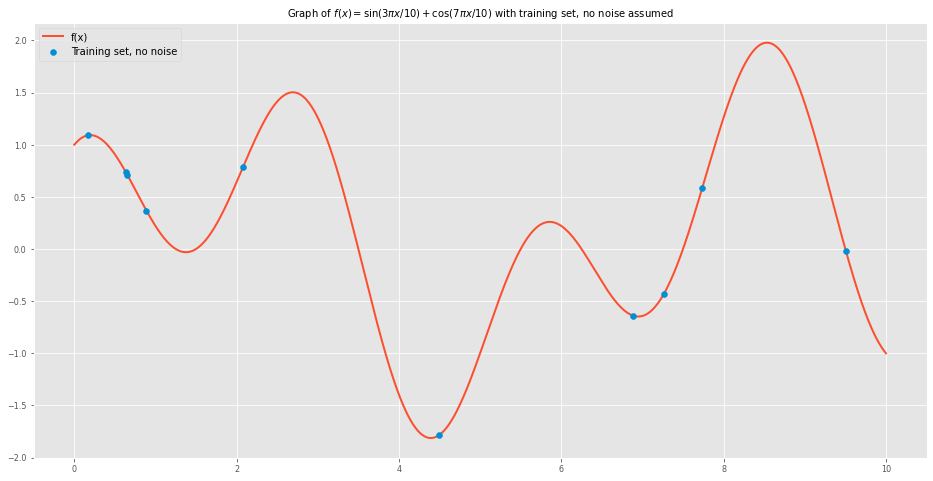

In [73]:
# Number of samples (training set). 
n = 10
x = np.random.rand(n)*10
x = np.sort(x)
t = f(x)

fig, ax = plt.subplots()
plt.plot(xx, yy, color=colors[1], label='f(x)', zorder=2)
plt.scatter(x, t, color=colors[0], label='Training set, no noise', zorder=3)

plt.legend(loc='upper left')
plt.title(r'Graph of $f(x) = \sin(3\pi x/10) + \cos(7\pi x/10)$ with training set, no noise assumed');

Next, we generate some training sample observations for the case when a gaussian noise is assumed:

In [74]:
# Error standard deviation. 
sigma_n = 0.2

# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)

# Observed target variable. 
t_n = t + epsilon

Let us see the error distribution.

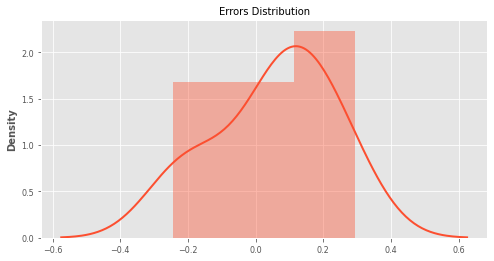

In [77]:
fig, ax = plt.subplots(figsize=(8, 4))
# Plot errors. 
sns.distplot(a=epsilon, color=colors[1], ax=ax)
ax.set(title='Errors Distribution');

Let us now visualize the sample data:

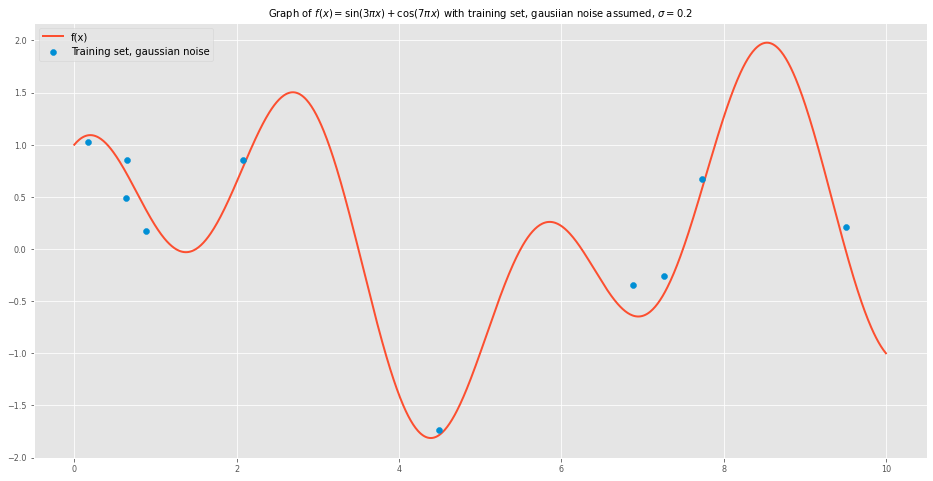

In [78]:
fig, ax = plt.subplots()
plt.plot(xx, yy, color=colors[1], label='f(x)', zorder=2)
plt.scatter(x, t_n, color=colors[0], label='Training set, gaussian noise', zorder=3)

plt.legend(loc='upper left')
plt.title(r'Graph of $f(x) = \sin(3\pi x) + \cos(7\pi x)$ with training set, gaussian noise assumed, $\sigma={}$'.format(sigma_n));

We now consider test data points on which we want to generate predictions.

In [79]:
#n_star = 1000
#x_star = np.sort(np.random.rand(n_star))
x_star = xx

## Kernel Function

A gaussian process is completely specified by its mean and covariance functions $m(x), \kappa(x,x')$. Usually, it is assumed $m(x)=0$, while a common choice for $\kappa(x,x')$ is the *squared exponential*, 

$$
\text{cov}(f(x_p), f(x_q)) = \kappa_{\sigma_f, \ell}(x_p, x_q) = \sigma_f \exp\left(-\frac{\lVert x_p - x_q\rVert^2}{2\ell^2} \right)
$$

where $\sigma_f , \ell >0$ are hyperparameters.

In [80]:
def kernel_function(x, y, sigma_f=1, l=1):
    return sigma_f*np.exp(-(np.linalg.norm(x-y)**2)/(2*l**2))

Let us select the parameters:

In [81]:
l = .8
sigma_f = 1

## Compute Covariance Matrices

Let us denote by $K(X, X) \in M_{n}(\mathbb{R})$, $K(X_*, X) \in M_{n_* \times n}(\mathbb{R})$ and $K(X_*, X_*) \in M_{n_*}(\mathbb{R})$ the covariance matrices applies to $x$ and  $x_*$. 

In [82]:
import itertools

def compute_cov_matrices(x, x_star, sigma_f=1, l=1, noise=True, sigma_n=0.1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(X) 
        - k_star = k(X_*, X)
        - K_star = K(X_*)
    """
    n = x.shape[0]
    n_star = x_star.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]
    K = np.array(K).reshape(n, n)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]
    K_star = np.array(K_star).reshape(n_star, n_star)
    
    k_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]
    k_star = np.array(k_star).reshape(n_star, n)

    if noise:
        K = K+(sigma_n**2)*np.eye(n)
    
    a = np.concatenate((K, k_star), axis=0)
    b = np.concatenate((k_star.T, K_star), axis=0)
    C = np.concatenate((a, b), axis=1)
    
    return (C, K, K_star, k_star)

## No noise assumption

We assume the observed values $t=(t_1,\ldots,t_n)^T$ in correspondance to the training set items $X=(x_1,\ldots,x_n)^T$ are precisely the values $$f=(f(x_1),\ldots,f(x_n))^T$$ 

In this case, given the set of test points $X^*=(x^*_1,\ldots,x^*_m)^T$ the joint distribution of $f$ and $f^*=(f(x_1^*),\ldots,f(x_m^*))^T$ is given by 

$$
\left(
\begin{array}{c}
f \\
f_*
\end{array}
\right)
\sim
\mathcal{N}(0, C)
$$

where 

$$
C = 
\left(
\begin{array}{cc}
K(X) & k(X, X^*) \\
k(X, X^*)^T & K(X^*)
\end{array}
\right)
$$
and

- $K(X)_{ij} = \kappa(x_i,x_j)$, with $i,j =1,\ldots, n$ 
- $k(X,X^*)_{ij} = \kappa(x_i,x^*_j)$, with $i=1,\ldots, n$  and $j=1,\ldots, m$
- $K(X^*)_{ij} = \kappa(x^*_i,x^*_j)$, with $i,j =1,\ldots, m$ 

Let us compute the components:

In [83]:
C_n, K_n, K_star_n, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=False)

Let us consider each component:

$K(X)$

In [84]:
print('Shape: {}'.format(K_n.shape))

Shape: (10, 10)


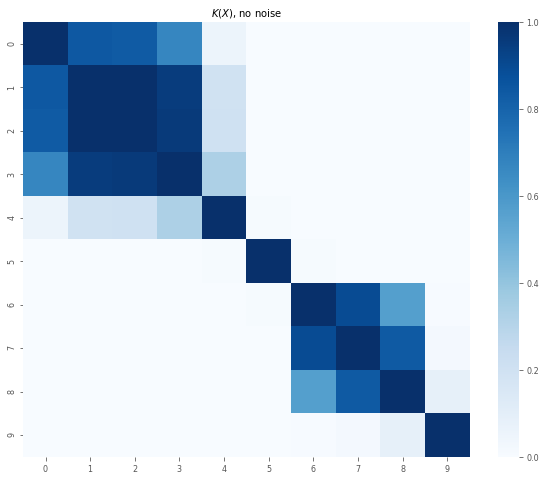

In [86]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_n, cmap='Blues', ax=ax)
plt.title('$K(X)$, no noise');

$K(X_*)$

In [87]:
print('Shape: {}'.format(K_star_n.shape))

Shape: (1000, 1000)


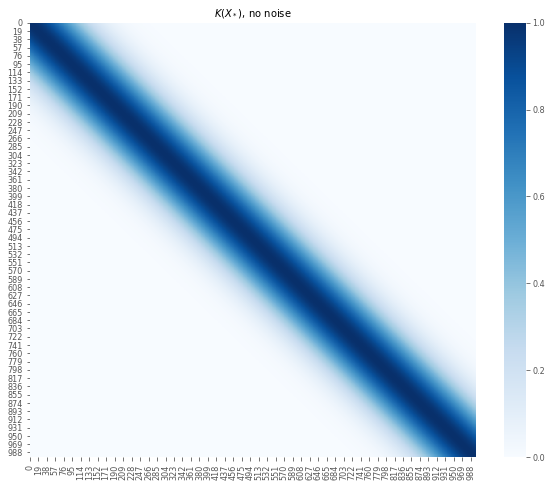

In [89]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star_n, cmap='Blues', ax=ax)
plt.title('$K(X_*)$, no noise');

$k(X_*,X)$

In [90]:
print('Shape: {}'.format(k_star.shape))

Shape: (1000, 10)


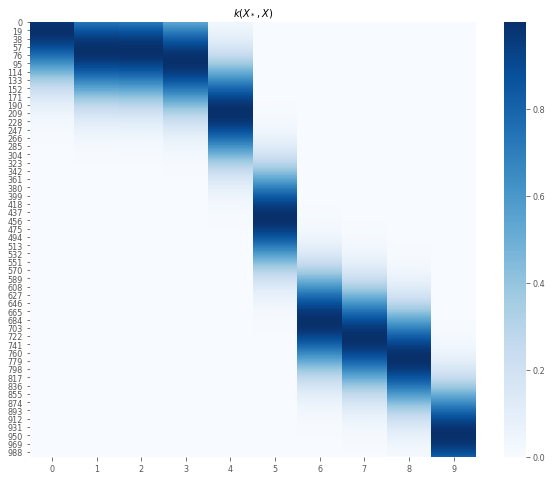

In [91]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=k_star, cmap='Blues', ax=ax)
plt.title('$k(X_*,X)$');

The covariance matrix $C_n$

In [92]:
print('Shape: {}'.format(C_n.shape))

Shape: (1010, 1010)


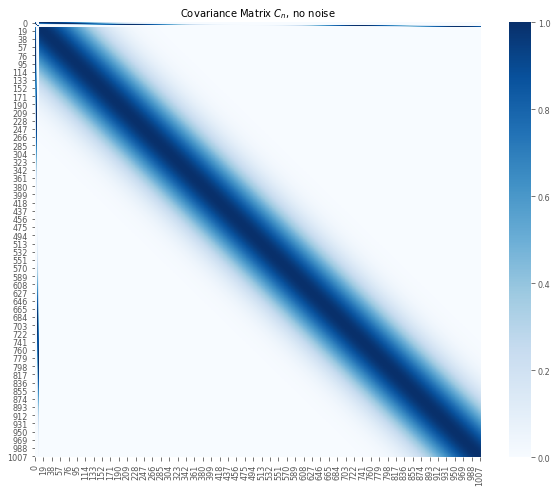

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=C_n, cmap='Blues', ax=ax)
plt.title('Covariance Matrix $C_n$, no noise');

The prior distribution for $f^*$ is $N(\mu, \Sigma)$, with $\mu=0$ and $\Sigma=K(X^*)$

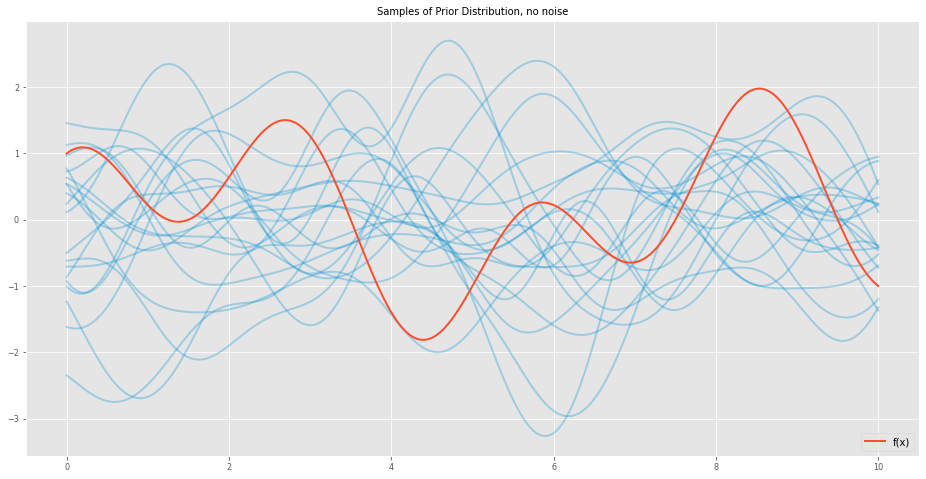

In [95]:
fig, ax = plt.subplots()
mean_z = np.zeros_like(xx)
for i in range(0, 20):
    # Sample from prior distribution. 
    z_star = np.random.multivariate_normal(mean=mean_z, cov=K_star_n)
    # Plot function.
    plt.plot(xx, z_star, color=colors[0], alpha=0.3)
plt.plot(xx, yy, color=colors[1], label='f(x)')
ax.set(title='Samples of Prior Distribution, no noise')
ax.legend(loc='lower right');

In [96]:
def compute_gpr_parameters(K, K_star, k_star, y):
    """Compute gaussian regression parameters."""
    n = K.shape[0]
    # Mean.
    f_bar_star = np.dot(k_star, np.dot(np.linalg.inv(K), y.reshape([n, d])))
    # Covariance.
    cov_f_star = K_star - np.dot(k_star, np.dot(np.linalg.inv(K), k_star.T))
    
    return (f_bar_star, cov_f_star)

In [97]:
m, c = compute_gpr_parameters(K_n, K_star_n, k_star, t)

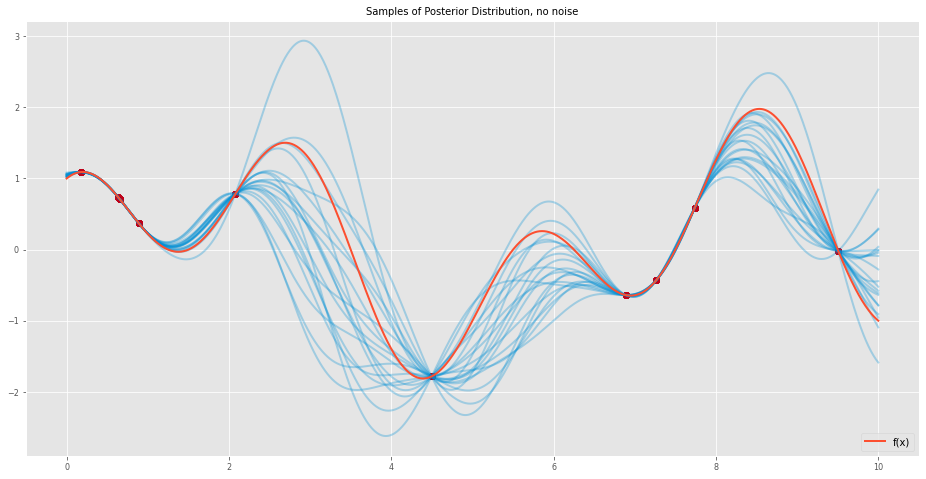

In [98]:
fig, ax = plt.subplots()
for i in range(0, 20):
    # Sample from joint distribution. 
    z_star = np.random.multivariate_normal(mean=m.ravel(), cov=c)
    # Plot function.
    plt.plot(xx, z_star, color=colors[0], alpha=0.3)
    plt.scatter(x,t, color=colors[7])
    
# Plot "true" linear fit.
plt.plot(xx, yy, color=colors[1], label='f(x)')
ax.set(title='Samples of Posterior Distribution, no noise')
ax.legend(loc='lower right');

In [99]:
def predict(x, X_train, t_train, noise=False):
    C, K, K_star, k_star = compute_cov_matrices(X_train, np.array([x]), l=l, sigma_n=sigma_n, sigma_f= sigma_f, noise=noise)
    m, c = compute_gpr_parameters(K, K_star, k_star, t_train)
    return m.item(),c.item()

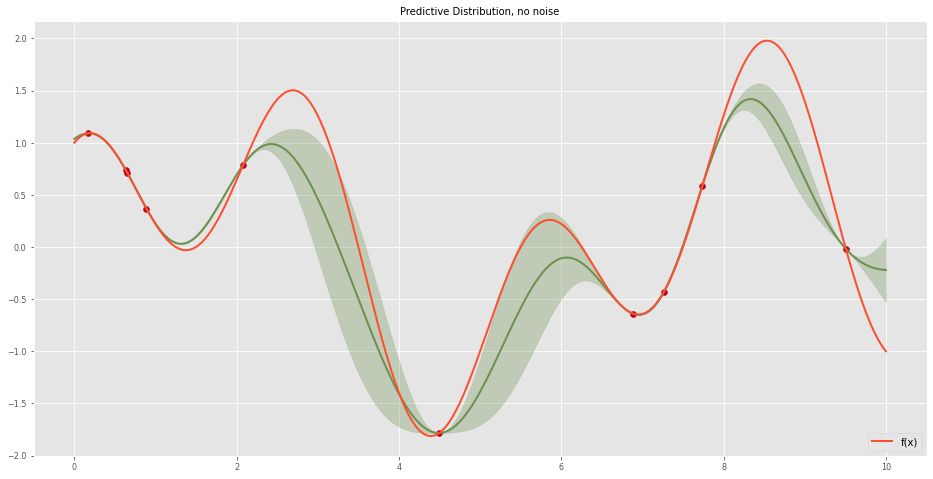

In [100]:
fig, ax = plt.subplots()
z_star = np.array([predict(z, x, t) for z in xx])

plt.plot(xx, z_star[:,0], color=colors[3])
plt.fill_between(xx, z_star[:,0]-z_star[:,1], z_star[:,0]+z_star[:,1], color=colors[3], alpha=.3)
plt.scatter(x,t, color=colors[7])
    
# Plot "true" linear fit.
plt.plot(xx, yy, color=colors[1], label='f(x)')
ax.set(title='Predictive Distribution, no noise')
ax.legend(loc='lower right');

## Gaussian noise assumption

The joint distribution  of $y$ and $f_*$ is given by 

$$
\left(
\begin{array}{c}
y \\
f_*
\end{array}
\right)
\sim
N(0, C)
$$

where 

$$
C = 
\left(
\begin{array}{cc}
K(X, X) + \sigma^2_n I & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{array}
\right)
$$

Observe that we need to add the term $\sigma^2_n I$ to the upper left component to account for noise (assuming additive independent identically distributed Gaussian noise). We now compute the matrix $C$.

In [101]:
C_g, K_g, K_star_g, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, sigma_n=sigma_n, l=l, noise=True)

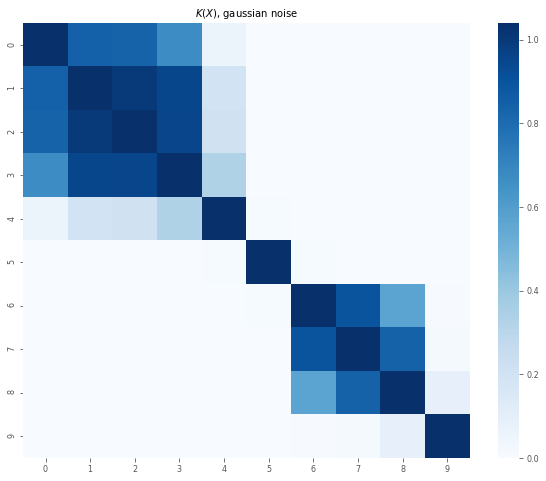

In [102]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_g, cmap='Blues', ax=ax)
plt.title('$K(X)$, gaussian noise');

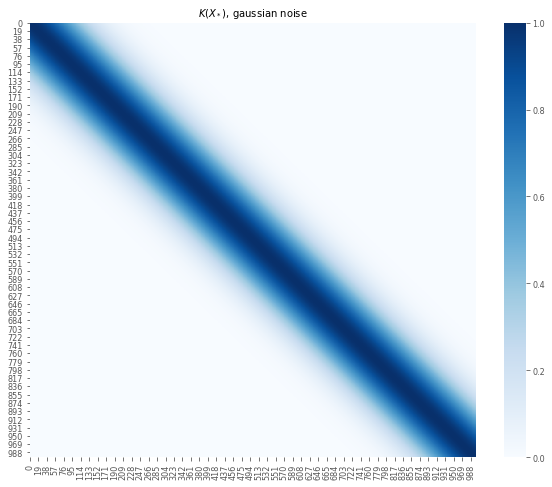

In [103]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star_g, cmap='Blues', ax=ax)
plt.title('$K(X_*)$, gaussian noise');

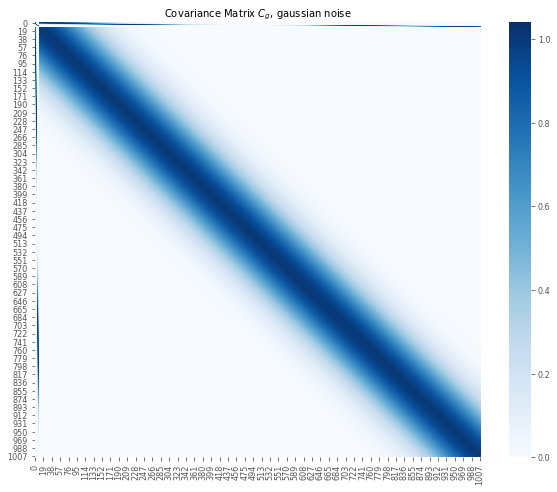

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=C_g, cmap='Blues', ax=ax)
plt.title('Covariance Matrix $C_g$, gaussian noise');

## Prior Distribution 

The prior distribution for $f_*$ is $N(\mu, \Sigma)$, with $\mu=0$ and $\Sigma$ defined by $\kappa(x,x')$. Let us visualize some sample functions from this prior:

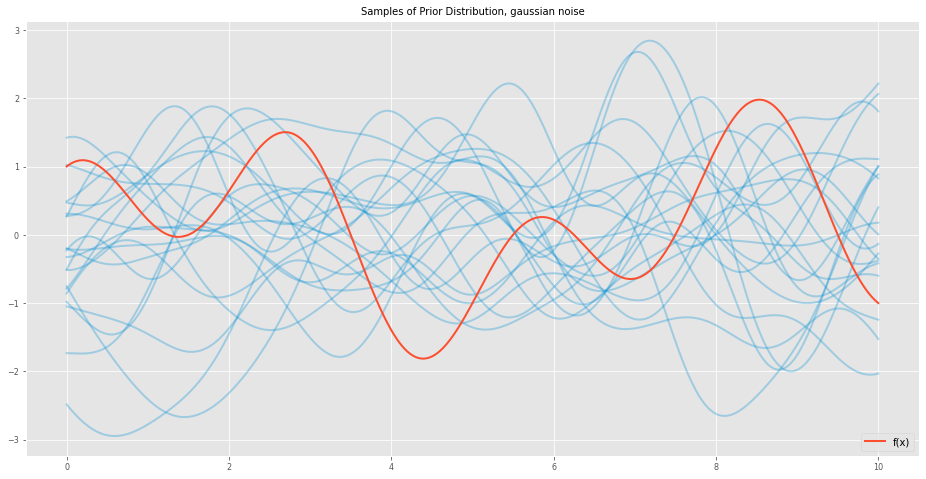

In [107]:
fig, ax = plt.subplots()
mean_z = np.zeros_like(xx)
for i in range(0, 20):
    # Sample from prior distribution. 
    z_star = np.random.multivariate_normal(mean=mean_z, cov=K_star_g)
    # Plot function.
    plt.plot(xx, z_star, color=colors[0], alpha=0.3)
plt.plot(xx, yy, color=colors[1], label='f(x)')
ax.set(title='Samples of Prior Distribution, gaussian noise')
ax.legend(loc='lower right');

In [108]:
m_g, c_g = compute_gpr_parameters(K_g, K_star_g, k_star, t)

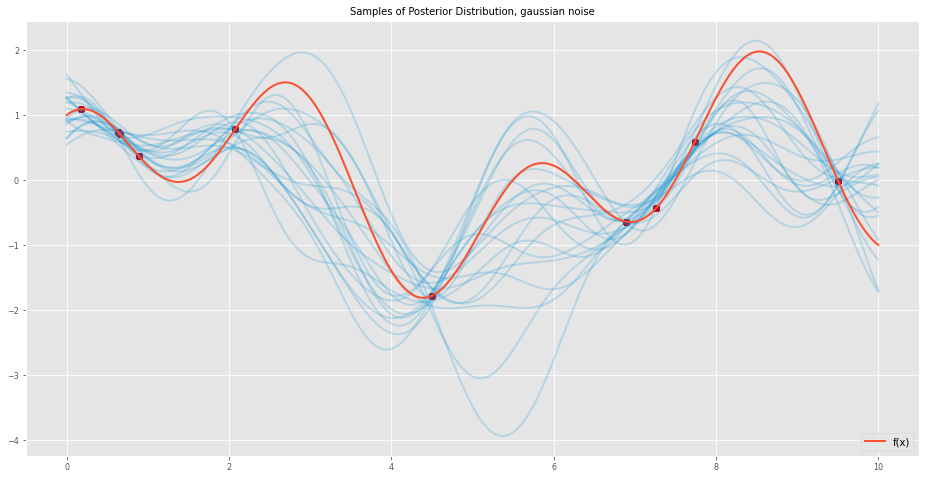

In [109]:
fig, ax = plt.subplots()
for i in range(0, 20):
    # Sample from joint distribution. 
    z_star = np.random.multivariate_normal(mean=m_g.ravel(), cov=c_g)
    # Plot function.
    plt.plot(xx, z_star, color=colors[0], alpha=0.2)
    plt.scatter(x,t, color=colors[7])
    
# Plot "true" linear fit.
plt.plot(xx, yy, color=colors[1], label='f(x)')
ax.set(title='Samples of Posterior Distribution, gaussian noise')
ax.legend(loc='lower right');

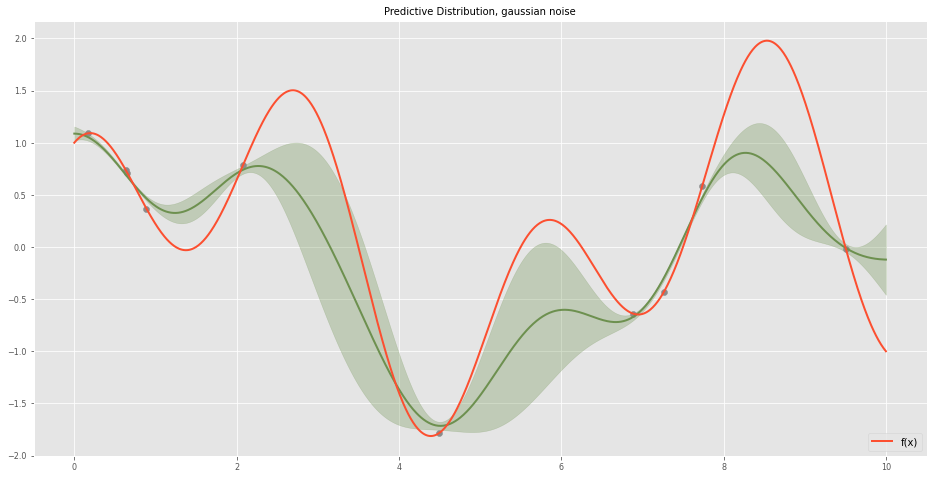

In [110]:
fig, ax = plt.subplots()
z_star = np.array([predict(z, x, t, noise=True) for z in xx])

plt.plot(xx, z_star[:,0], color=colors[3])
plt.fill_between(xx, z_star[:,0]-z_star[:,1], z_star[:,0]+z_star[:,1], color=colors[3], alpha=.3)
plt.scatter(x,t, color=colors[4])
    
# Plot "true" linear fit.
plt.plot(xx, yy, color=colors[1], label='f(x)')
ax.set(title='Predictive Distribution, gaussian noise')
ax.legend(loc='lower right');

## Hyperparameters

We now study the effect of the hyperparameters $\sigma_f$ and $\ell$ of the kernel function defined above. 

- The hyperparameter $\sigma_f$ describes the amplitude of the function. 

- The hyperparameter $\ell$ is a locality parameter, i.e. how far the points interact. 

Let us see some concrete examples:

- $\sigma_f = 2$ and $\ell = 1$

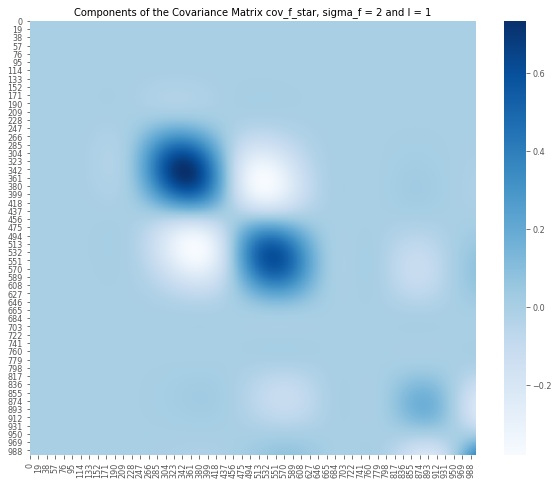

In [111]:
l = 1
sigma_f = 2

# Compute covariance matrices. 
C, K, K_star, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=False)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star, k_star, t)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
plt.title(f'Components of the Covariance Matrix cov_f_star, sigma_f = {sigma_f} and l = {l}');

In this case the values of the posterior covariance matrix are not that localized. This means that we expect points far away can still have some interaction, i.e. the fit becomes more global. Let us plot the resulting fit:

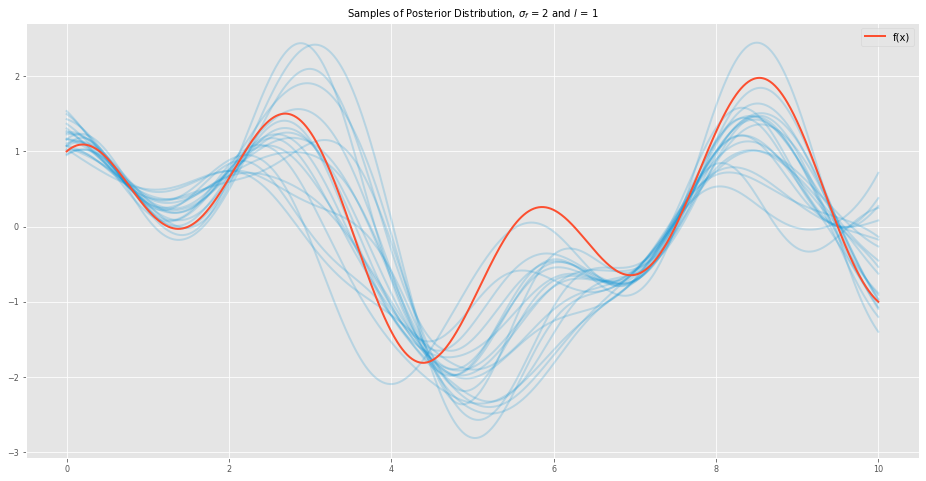

In [112]:
C, K, K_star, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=True)
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star, k_star, t)

fig, ax = plt.subplots()
for i in range(0, 20):
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    plt.plot(xx, z_star, color=colors[0], alpha=0.2);
plt.plot(xx, yy, color=colors[1], label='f(x)')
plt.title(f'Samples of Posterior Distribution, $\sigma_f$ = {sigma_f} and $l$ = {l}')
plt.legend(loc='upper right');

- $\sigma_f = 2$ and $\ell = 0.001$

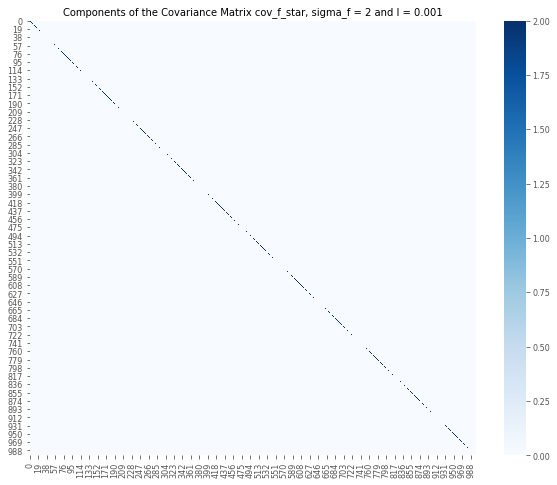

In [113]:
l = 0.001
sigma_f = 2

# Compute covariance matrices. 
C, K, K_star, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=True)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star, k_star, t)
# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
plt.title(f'Components of the Covariance Matrix cov_f_star, sigma_f = {sigma_f} and l = {l}');

In contrast, we see that for these set of hyper parameters the higher values of the posterior covariance matrix are concentrated along the diagonal. This means that we expect points far away to have no effect on each other, i.e. the fit becomes more local. Let us plot the resulting fit:

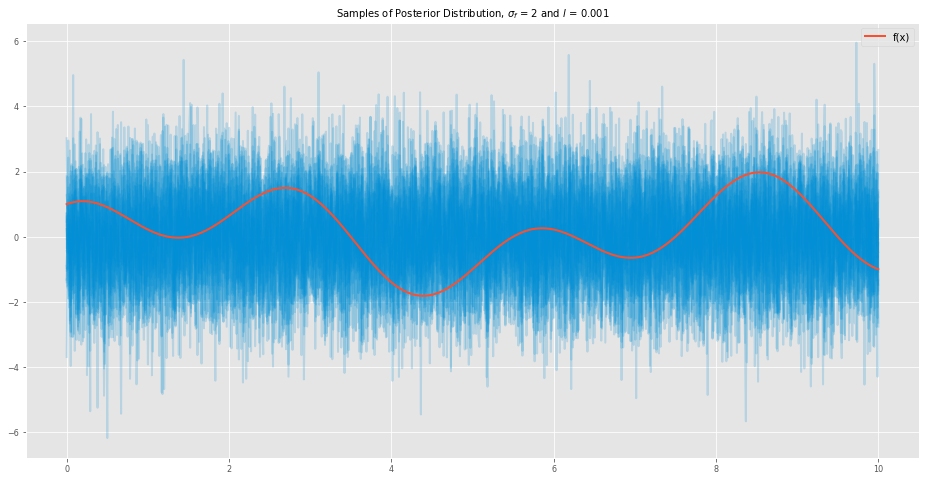

In [114]:
fig, ax = plt.subplots()
for i in range(0, 20):
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    plt.plot(xx, z_star, color=colors[0], alpha=0.2);
plt.plot(xx, yy, color=colors[1], label='f(x)')
plt.title(f'Samples of Posterior Distribution, $\sigma_f$ = {sigma_f} and $l$ = {l}')
plt.legend(loc='upper right');

Hence, we see that the hyperparameter $\ell$ somehow encodes the "complexity" and "locality" of the model. 

- $\sigma_f = 50$ and $\ell = 0.1$

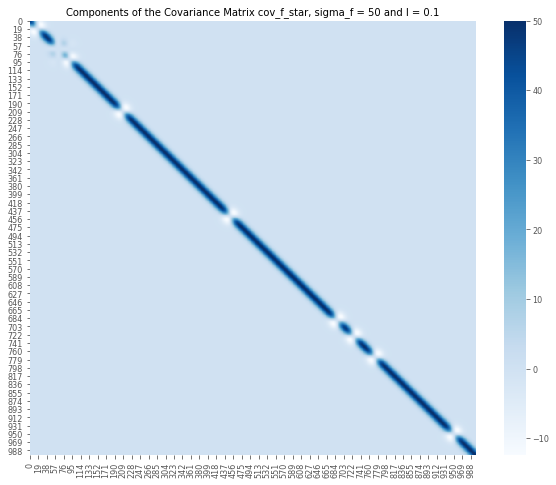

In [115]:
l = 0.1
sigma_f = 50

# Compute covariance matrices. 
C, K, K_star, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=True)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star, k_star, t)
# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
plt.title(f'Components of the Covariance Matrix cov_f_star, sigma_f = {sigma_f} and l = {l}');

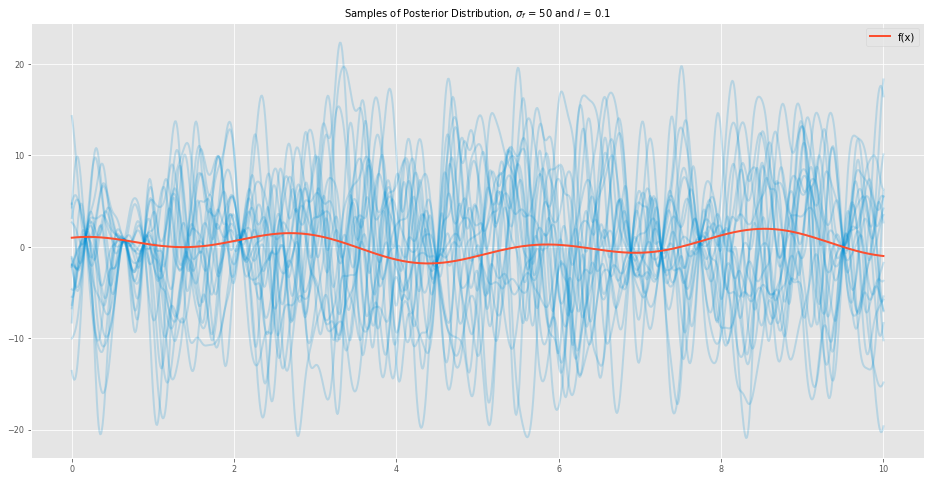

In [116]:
fig, ax = plt.subplots()
for i in range(0, 20):
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    plt.plot(xx, z_star, color=colors[0], alpha=0.2);
plt.plot(xx, yy, color=colors[1], label='f(x)')
plt.title(f'Samples of Posterior Distribution, $\sigma_f$ = {sigma_f} and $l$ = {l}')
plt.legend(loc='upper right');

The hyperparameter $\sigma_f$ encodes the amplitude of the fit. 

## GaussianProcessRegressor from Scikit-Learn

In [137]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

### Construct Training Set

In [138]:
# Set dimension. 
d = 1
# Number of training points.
n = 1000
# Length of the training set. 
L = 2
# Generate training features.
x = np.linspace(start=0, stop=L, num=n)
X = x.reshape(n, d)
# Error standar deviation. 
sigma_n = 0.4
# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)
# Generate non-linear function.
def f(x):
    
    f = np.sin((4*np.pi)*x) + np.sin((7*np.pi)*x) + np.sin((3*np.pi)*x) 
    
    return(f)

f_x = f(x)

# Observed target variable. 
y = f_x + epsilon

### Construct Test Set

In [139]:
n_star = n + 300
x_star = np.linspace(start=0, stop=(L + 0.5), num=n_star)

X_star = x_star.reshape(n_star, d)

### Define Kernel and Model

In [140]:
# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-2, 1e2))
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10, )

### Model Fit + Predictions

In [141]:
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)
# Make the prediction on test set.
y_pred = gp.predict(X_star)

In [142]:
# Generate samples from posterior distribution. 
y_hat_samples = gp.sample_y(X_star, n_samples=n_star)
# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=1).squeeze()
# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

### Visualize Results

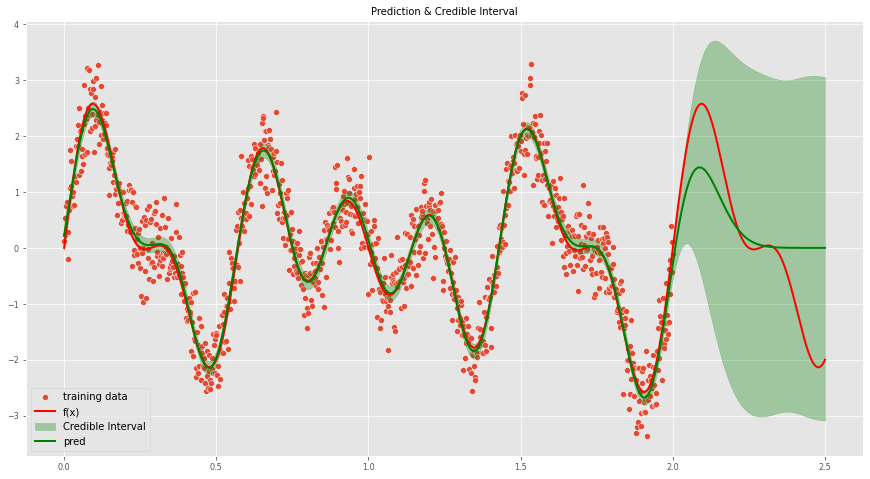

In [143]:
fig, ax = plt.subplots(figsize=(15, 8))

# Plot training data.
sns.scatterplot(x=x, y=y, label='training data', ax=ax);

# Plot "true" linear fit.
sns.lineplot(
    x=x_star, 
    y=f(x_star), 
    color='red', 
    label='f(x)', 
    ax=ax
)

# Plot corridor. 
ax.fill_between(
    x=x_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='green',
    alpha=0.3, 
    label='Credible Interval'
)

# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred')
ax.set(title='Prediction & Credible Interval')
ax.legend(loc='lower left');